In [15]:
# Rod length 2d with mass m and moment of intertia I
# gets pushed by perpendicular force f at one end.  
# What's the acceleration of the CofG and the angular acceleration?
# x is along rod, y is perpendicular to rod in direction of f

import sympy as sp
import sympy.physics.mechanics as me
sp.init_printing()

m = sp.symbols("m") # mass of rod
d = sp.Symbol("d")  # half length of rod
x = sp.Symbol("x")  # position along rod
ld = m/(2*d)        # length desnsity
I = sp.integrate(ld*x*x, (x, -d, d))    # moment of inertia evenly distributed
f = sp.Symbol('f')  # instantaneous force


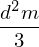

In [21]:
I

In [10]:
alpha = sp.Symbol("alpha")  # rotational acceleration
a = sp.Symbol("a")          # linear acceleration
eq1 = sp.Eq(alpha*I, f*d)   # rotational torque
eq2 = sp.Eq(m*a, f)         # linear acceleration
sol = sp.solve([eq1, eq2], [a, alpha])
sol

{a: f/m, alpha: 3*f/(d*m)}

In [11]:
deltat = sp.Symbol("\delta t")
vy = (a*deltat + x*alpha*deltat) # velocity forward at position x after infinitesimal time
vy = vy.subs(sol).simplify()
print("vy:")
display(vy)
print("pivot point: x=")
display(sp.solve(vy, x))


kineticenergy = sp.integrate(ld/2*vy*vy, (x, -d, d))
workdone = 0.5*f*vy.subs(x, d)  # force times distance

print("kineticenergy:")
display(kineticenergy)
print("workdone?:")
display(workdone)

vy:


\delta t*f*(d + 3*x)/(d*m)

pivot point: x=


[-d/3]

kineticenergy:


2*\delta t**2*f**2/m

workdone?:


2.0*\delta t*f**2/m

In [4]:
# according to section 3 in https://arxiv.org/abs/1708.05062
print("kinetic energy")
angularenergy = (alpha*deltat)**2*I/2
linearenergy = m*(a*deltat)**2/2
KE = (linearenergy + angularenergy).subs(sol).simplify()
KE

kinetic energy


2*\delta t**2*f**2/m

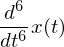

In [28]:
xd = me.dynamicsymbols('x', 6)
xd

In [12]:
# Next up: express the above in terms of rigid bodies: 
# https://docs.sympy.org/latest/modules/physics/mechanics/masses.html#rigid-body
import sympy as sp
import sympy.physics.mechanics as me

m = sp.Symbol("m")
d = sp.Symbol('d')

lx = sp.Symbol('lx')
ld = m/(2*d)                         # length density
I = sp.integrate(ld*lx*lx, (lx, -d, d)) # moment of inertia evenly distributed

f = sp.Symbol('f')

t = sp.Symbol('t')
x, y, theta = me.dynamicsymbols('x y theta')
xv, yv, thetav = me.dynamicsymbols('xv yv thetav')
xd, yd, thetad = me.dynamicsymbols('x y theta', 1)

BaseFrame = me.ReferenceFrame('BaseFrame')
RodFrame = BaseFrame.orientnew('RodFrame', 'Axis', [theta, BaseFrame.z])
RodFrame.set_ang_vel(BaseFrame, thetav*BaseFrame.z)
origin  = me.Point('origin')
rodcentre  = origin.locatenew('rodcentre', x*BaseFrame.x + y*BaseFrame.y)
rodcentre.set_vel(BaseFrame, xv*BaseFrame.x + yv*BaseFrame.y)
#rodcentre.set_vel(RodFrame, 0)

Izz = me.outer(RodFrame.z, RodFrame.z)*I
rodbody = me.RigidBody(name="rod", masscenter=rodcentre, 
                       frame=RodFrame, mass=m, inertia=(Izz, rodcentre))

rodtip = rodcentre.locatenew('rodtip', d*RodFrame.x)
rodtip.set_vel(BaseFrame, rodtip.pos_from(origin).diff(t, BaseFrame))



In [13]:
forces = [ (rodtip, f*RodFrame.y) ]
#forces = [ (rodtip, f*BaseFrame.y) ]
bodies = [ rodbody ]

kinematic_equations = [xv-xd, yv-yd, thetav-thetad]

KM = me.KanesMethod(BaseFrame, 
                     q_ind=[x, y, theta], 
                     u_ind=[xv, yv, thetav],
                     kd_eqs=kinematic_equations)
fr, frstar = KM.kanes_equations(bodies, forces)
display(fr)
display(frstar)

Matrix([
[                           -f*sin(theta(t))],
[                            f*cos(theta(t))],
[f*(d*sin(theta(t))**2 + d*cos(theta(t))**2)]])

Matrix([
[           -m*Derivative(xv(t), t)],
[           -m*Derivative(yv(t), t)],
[-d**2*m*Derivative(thetav(t), t)/3]])

In [14]:
from pydy.system import System
import numpy as np

initial_conditions = {x:0, y:0, theta:0.0, 
                      xv:0, yv:0, thetav:0.}
dval = 4.0
sys = System(KM,
             constants={m: 1.0, f:0.3, d:dval },
             initial_conditions=initial_conditions,
             times=np.linspace(0.0, 6, 350))
y1 = sys.integrate()


In [30]:
y1.shape

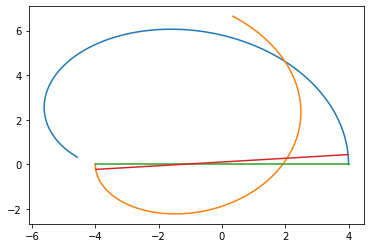

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

ax, ay, atheta = y1[:,0], y1[:,1], y1[:,2]
plt.plot(ax+dval*np.cos(atheta), ay+dval*np.sin(atheta))
plt.plot(ax-dval*np.cos(atheta), ay-dval*np.sin(atheta))

plt.plot([-dval,dval],[0,0])
i = 50
plt.plot([ax[i]-dval*np.cos(atheta[i]), ax[i]+dval*np.cos(atheta[i])], 
         [ay[i]-dval*np.sin(atheta[i]), ay[i]+dval*np.sin(atheta[i])])

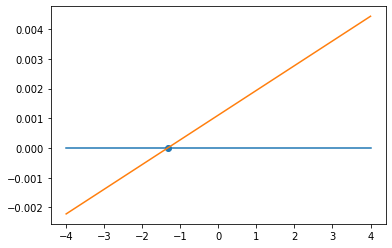

In [52]:
plt.plot([-dval,dval],[0,0])
i = 5
plt.plot([ax[i]-dval*np.cos(atheta[i]), ax[i]+dval*np.cos(atheta[i])], 
         [ay[i]-dval*np.sin(atheta[i]), ay[i]+dval*np.sin(atheta[i])])
plt.scatter([-dval/3], [0])

In [2]:
# https://github.com/sympy/sympy/issues/17761
t = sp.Symbol('t')

# In that issue is the work-around then to use:
#t = sp.Symbol('t')
#Q.pos_from(P).diff(t, A)  # ~= Q.vel(A)

In [ ]:
# Is the work-around then to use:
t = sp.Symbol('t')
Q.pos_from(P).diff(t, A)  # ~= Q.vel(A)


In [ ]:
# Then handle the slipping rod from here:
# https://physics.stackexchange.com/questions/80603/can-i-make-a-rod-in-the-vertical-plane-move-with-its-one-end-on-the-ground-in-a/90894#90894
